# Reading New TEC Data and Producing Output Files

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [5]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA/EIAmerging')
import functions

In [ ]:
functions = il.reload(functions)
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/tec_data/'
files = os.listdir(path)
files = [path + i for i in files]

for f in files:
    if f[-4:] != '.txt':
        files.remove(f)
print('No. of files to process:', len(files))



glat_lim = 40

glon_min = -60
glon_max = -40
mlon_min = 15
mlon_max = 25
zone_mlon = '20E'

    
tec_g = []
columns = ['GDLAT', 'GLON', 'TEC', 'DT']
grnd_tec = pd.DataFrame(columns=columns)

def process_file(f):
    # Read function passed continuously during multiple processing to quicken the process
    df = pd.read_csv(f, sep=r'\s+')
    d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
    df['DT'] = d
    # Dropping unnecassary columns from the Dataframe
    df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
    if 'GDALT' in df.columns:
        df = df.drop(['GDALT'], axis=1)
    df = df[(df.GDLAT > -glat_lim) & (df.GDLAT < glat_lim) & (df.GLON > glon_min) & (df.GLON < glon_max)].reset_index(drop=True)
    return df    
# Speeding the process by using parallel processing
tec_g = p_map(process_file, files)  # Parallel processing with progress bar
print('1')
grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
grnd_tec0 = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])



# Reading the Kp index values for all the days and filtering undesired points where Kp > 3
file = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/kp_f107_data.txt'
kp = pd.read_csv(file,sep=r'\s+')
year = 2023
date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
m, d = zip(*date_kp)
kp['DT'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
kp['kp'] = [i/10 for i in kp.Kp]
kp = kp.drop(['Year', 'Hour','Kp'], axis = 1)
# the below command is messing up the kp values as it is trying to fit the kp value 
# based on weighted average of all the known points surrounding it
grnd_tec0 = pd.merge_asof(grnd_tec0.sort_values('DT'), kp.sort_values('DT'), on='DT', direction='nearest')
#grnd_tec0 = merged_data.drop(['date'], axis = 1)
print('2')

# Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
t_start = dt.datetime.now() # just a timer
with Pool(40) as pool:
    p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
pool.close()
pool.join()
# Separating the data from output list 
sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)



# Reordering the outputs and applying further conditions on magnetic coordinates
grnd_temp = pd.DataFrame({'DT': sat_date, 'DOY': grnd_tec0.DOY, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt, 'kp':grnd_tec0.kp, 'F10.7':grnd_tec0['F10.7']})
grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= mlon_max) & (grnd_tec1.MLON >= mlon_min)].reset_index(drop=True)
grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)




# Writing the output into csv files for easy post processing
grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/feb_22_24_2023.csv', index=False)

t_total = dt.datetime.now() - t_start
print(t_total)

# Adding SMYH, SMI and SMR indices 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gzip
import os
import io
import datetime as dt

In [117]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [118]:
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/supermag_data/'
file = path + '20250207-00-27-supermag.txt'

df = pd.read_csv(file, delim_whitespace=True)

# Combine date and time columns into a single datetime column
df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])

# Drop the original date/time columns if not needed
df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second'])

# Set the Timestamp as the index
#df.set_index('time', inplace=True)

df_int = pd.DataFrame({
    'time': df['time'][:-1] + dt.timedelta(seconds=30),
    'SME': (df['SME'][:-1].values + df['SME'][1:].values) / 2,
    'SMR': (df['SMR'][:-1].values + df['SMR'][1:].values) / 2,
})

df = pd.concat([df, df_int]).sort_values(by='time').reset_index(drop=True)
print(df)

           SME    SMR                time
0        265.0 -14.10 2023-01-01 00:00:00
1        263.5 -14.05 2023-01-01 00:00:30
2        262.0 -14.00 2023-01-01 00:01:00
3        267.5 -14.00 2023-01-01 00:01:30
4        273.0 -14.00 2023-01-01 00:02:00
...        ...    ...                 ...
1051194   61.0  -0.80 2023-12-31 23:57:00
1051195   59.0  -0.80 2023-12-31 23:57:30
1051196   57.0  -0.80 2023-12-31 23:58:00
1051197   57.0  -0.80 2023-12-31 23:58:30
1051198   57.0  -0.80 2023-12-31 23:59:00

[1051199 rows x 3 columns]


In [119]:
data = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/EIAmerging/feb_22_24_2023.csv')
data['DT'] = pd.to_datetime(data['DT'])

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])

# Convert MLT to timedelta
data['MLT_del'] = pd.to_timedelta(data['MLT'], unit='h')

# Normalize DT (set time to 00:00:00) and add MLT shift
data['MLT_dt'] = (data['DT']).dt.normalize() + data['MLT_del']
dt_hours = data['DT'].dt.hour
data.loc[dt_hours < data['MLT'], 'MLT_dt'] -= pd.Timedelta(days=1) # this is to accomodate for the day change for this negative longitude regions

#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'] >= 24, data['MLT_dt'] - pd.Timedelta(days=1))
#data['MLT_dt'] = data['MLT_dt'].mask(data['MLT'], data['MLT_dt'] + pd.Timedelta(days=1))
data = data.drop(columns=['MLT_del', 'index'])

print(data)
print(data['MLT_dt'][20139:20145])

                        DT  DOY       TEC       MLAT        MLT   kp  F10.7  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  156.3   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  156.3   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  156.3   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  156.3   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  156.3   
...                    ...  ...       ...        ...        ...  ...    ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7  155.9   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7  155.9   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7  155.9   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7  155.9   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7  155.9   

          SME    SMR                        MLT_dt 

In [120]:
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + 'symh00584732.txt'

data_symh = []

with open(file, 'r') as file:
    for line in file:
        # Extract date and hour from the header (positions 14-23)
        date_str = '20'+line[12:18]  # Format: YYYYMMDD
        hour_str = line[19:21]  # Format: HH
        
        # Convert to datetime
        base_time = dt.datetime.strptime(date_str + hour_str, "%Y%m%d%H")
        
        # Extract SYMH values (positions 44 onwards, 60 values)
        symh_values = line[42:].split()
        
        # Generate timestamps for each minute
        for i, symh in enumerate(symh_values):
            timestamp = base_time + dt.timedelta(minutes=i, seconds=30) # added extra 30 seconds here for easy time matching with original tec data
            data_symh.append([timestamp, int(symh)])  # Convert symh to integer

# Create a DataFrame
df = pd.DataFrame(data_symh, columns=["time", "SYMH"])

# Save to CSV (optional)
df.to_csv(path+"symh_data.csv", index=False)

data = pd.merge(data, df, left_on='DT', right_on='time', how='left')
data = data.drop(columns=['time'])
print(data)

data.to_csv(path+'full_feb_22_24_2023.csv')

                        DT  DOY       TEC       MLAT        MLT   kp  F10.7  \
0      2023-02-20 00:02:30   51   8.82176 -31.621006  19.843212  0.7  156.3   
1      2023-02-20 00:02:30   51   8.51370 -31.949100  19.892839  0.7  156.3   
2      2023-02-20 00:02:30   51   8.18117 -32.281918  19.943026  0.7  156.3   
3      2023-02-20 00:02:30   51   8.74736 -32.618790  19.993800  0.7  156.3   
4      2023-02-20 00:02:30   51   8.63780 -32.959057  20.045186  0.7  156.3   
...                    ...  ...       ...        ...        ...  ...    ...   
876710 2023-02-26 23:57:30   57  29.12090  27.004009  20.244849  5.7  155.9   
876711 2023-02-26 23:57:30   57  30.30760  32.585384  20.236152  5.7  155.9   
876712 2023-02-26 23:57:30   57  29.95140  33.627403  20.247268  5.7  155.9   
876713 2023-02-26 23:57:30   57  26.77100  36.779762  20.278681  5.7  155.9   
876714 2023-02-26 23:57:30   57  25.23070  37.838436  20.288543  5.7  155.9   

          SME    SMR                        MLT_dt 

# Plotting the Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [3]:
path = f'{scratch}Qingyu_Cesar_EIA/EIAmerging/'
file = path + 'full_feb_22_24_2023.csv'

df = pd.read_csv(file)
df = df[(df['MLAT'] <= 31) & (df['MLAT'] >= -30)].reset_index()

df['DT'] = pd.to_datetime(df['DT'])
df['MLT_dt'] = pd.to_datetime(df['MLT_dt'])
df = df.drop(columns = ['index','Unnamed: 0'])

start_date = '2023-02-22'
end_date = '2023-02-25'
df = df[(df['MLT_dt'] >= start_date) & (df['MLT_dt'] <= end_date)]
df = df.drop(columns=[])
print(df)


                        DT  DOY       TEC       MLAT        MLT   kp  F10.7  \
252757 2023-02-22 03:32:30   53   8.85291 -25.055815   0.005033  0.3  148.6   
252767 2023-02-22 03:32:30   53   9.87086 -24.345940   0.018867  0.3  148.6   
252773 2023-02-22 03:32:30   53  10.09130 -23.631500   0.033341  0.3  148.6   
252781 2023-02-22 03:32:30   53  13.52900 -22.912184   0.048434  0.3  148.6   
252802 2023-02-22 03:32:30   53  15.09410 -21.702824   0.004362  0.3  148.6   
...                    ...  ...       ...        ...        ...  ...    ...   
620694 2023-02-25 04:02:30   56  30.59730   2.348387  23.951309  0.3  273.7   
620706 2023-02-25 04:02:30   56  28.91210   3.238025  23.969626  0.3  273.7   
620716 2023-02-25 04:02:30   56  32.25470   4.131188  23.988017  0.3  273.7   
620740 2023-02-25 04:02:30   56  33.78460   7.353010  23.980307  0.3  273.7   
620748 2023-02-25 04:02:30   56  24.04920   8.262088  23.998301  0.3  273.7   

         SME   SMR                        MLT_dt  S

In [4]:
# Define the MLAT bins from -30 to 30 with a step of 1
mlat_bins = np.arange(-30,31,1)
df['MLAT_bin'] = pd.cut(df['MLAT'], bins=mlat_bins, labels=mlat_bins[:-1])
df['MLT_dt_bin'] = df['MLT_dt'].dt.floor('10T')
df1 = df.drop(columns = ['MLT', 'MLAT', 'DT', 'DOY'])

# Group by DT and MLAT_bin, then take the mean of other columns
df1 = df1.groupby(['MLT_dt_bin', 'MLAT_bin']).mean(numeric_only=True).reset_index()
df1['MLAT_bin'] = df1['MLAT_bin'].astype(int)
df1.rename(columns={'MLAT_bin': 'MLAT'}, inplace=True)
df1.rename(columns={'MLT_dt_bin': 'MLT_dt'}, inplace=True)
print(df1)


                   MLT_dt  MLAT        TEC   kp  F10.7         SME  \
0     2023-02-22 00:00:00   -30   7.736019  0.3  148.6   64.944444   
1     2023-02-22 00:00:00   -29   8.699032  0.3  148.6   63.052632   
2     2023-02-22 00:00:00   -28   9.801842  0.3  148.6   63.365385   
3     2023-02-22 00:00:00   -27   9.610924  0.3  148.6   63.550000   
4     2023-02-22 00:00:00   -26  11.735474  0.3  148.6   62.980000   
...                   ...   ...        ...  ...    ...         ...   
25915 2023-02-24 23:50:00    25  15.432040  0.3  273.7  121.100000   
25916 2023-02-24 23:50:00    26  14.915367  0.3  273.7  110.666667   
25917 2023-02-24 23:50:00    27  14.589400  0.3  273.7   88.500000   
25918 2023-02-24 23:50:00    28        NaN  NaN    NaN         NaN   
25919 2023-02-24 23:50:00    29        NaN  NaN    NaN         NaN   

                SMR       SYMH  
0      2.500000e-02 -13.666667  
1      1.315789e-02 -13.684211  
2     -4.230769e-02 -13.846154  
3      2.775558e-18 -13.750

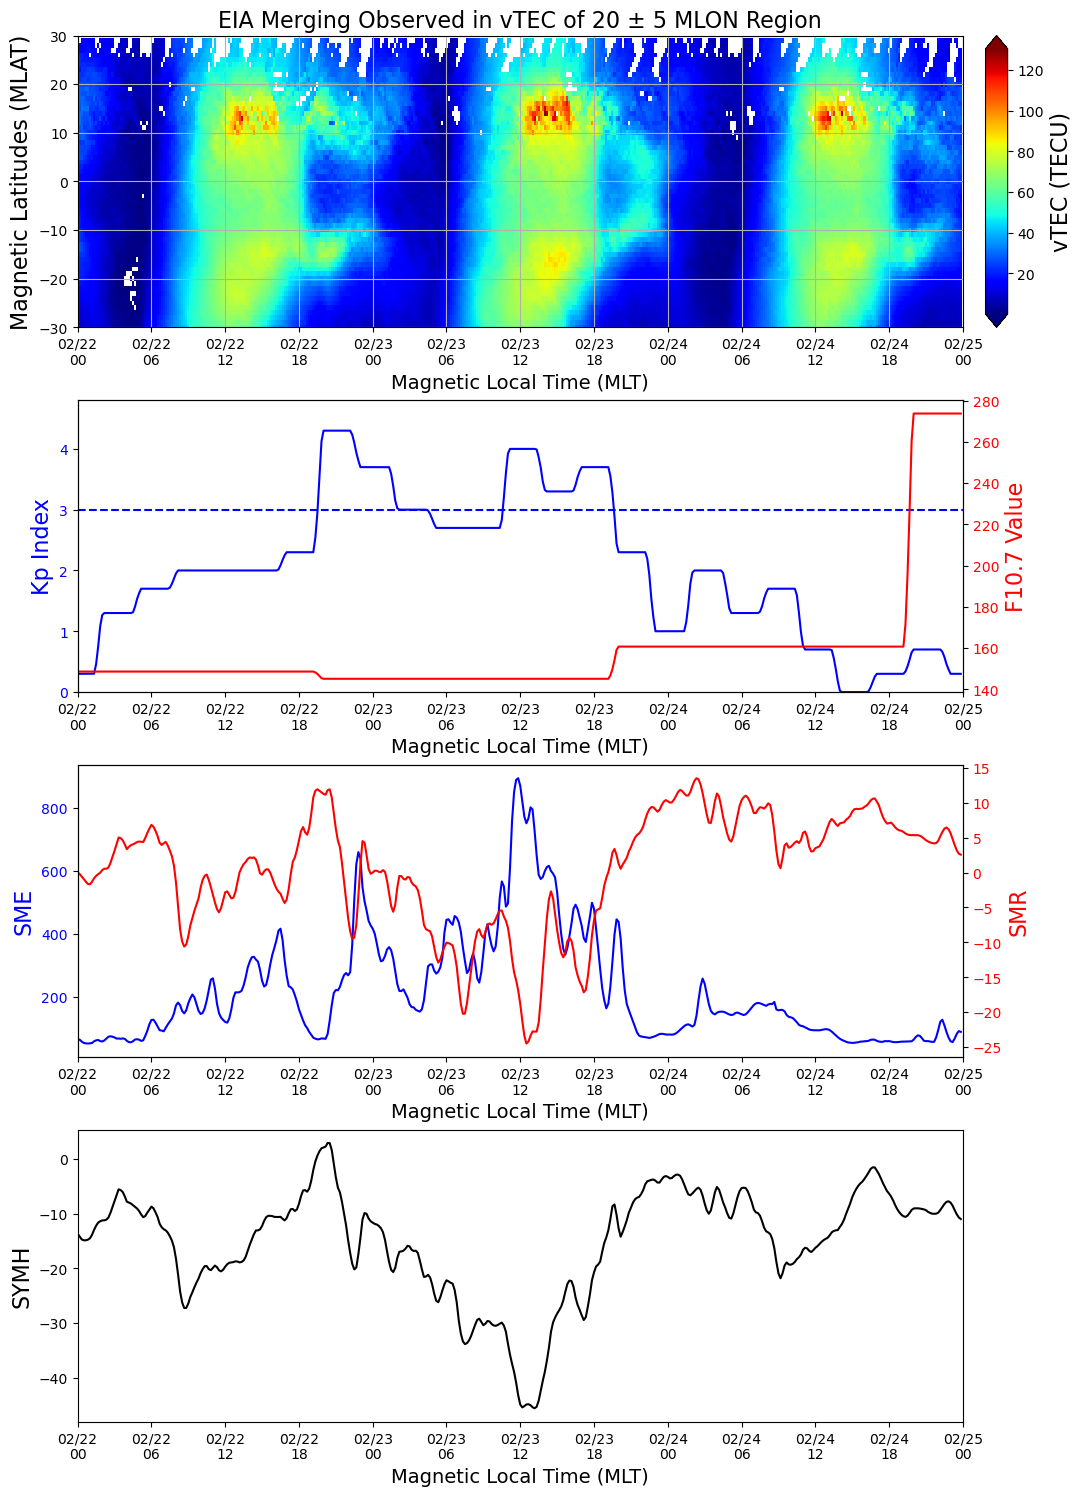

In [51]:
pivot_df = df1.pivot(index='MLAT', columns='MLT_dt', values='TEC')
X,Y = np.meshgrid(pivot_df.columns.unique(), pivot_df.index.unique())
Z = pivot_df.values.reshape(X.shape)


fig = plt.figure(figsize=(12,18))
specs = fig.add_gridspec(4, 2, width_ratios = [1, 0.025], height_ratios=[1,1,1,1], hspace=0.25, wspace=0.05)

# First Plot - TEC
ax1 = fig.add_subplot(specs[0,0])
pcm = ax1.pcolormesh(X, Y, Z, shading='auto', cmap='jet')

#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%m/%d'))
#ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
#ax1.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
#ax1.set_xlabel('Magnetic Local Time (MLT)', fontsize=16)
ax1.set_ylabel('Magnetic Latitudes (MLAT)', fontsize=16)
ax1.set_title('EIA Merging Observed in vTEC of 20 ± 5 MLON Region', fontsize = 16)
ax1.set_ylim(-30,30)
ax1.grid(True)
# Add vertical lines at specific datetime points
#ax1.axvline(pd.Timestamp('2023-02-23 00:00:00'), color='green', linestyle='--', linewidth=2, label='Feb 24 Midnight')
#ax1.axvline(pd.Timestamp('2023-02-24 00:00:00'), color='green', linestyle='--', linewidth=2, label='Feb 25 Midnight')
cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(pcm, cax = cbar_ax, label= 'vTEC (TECU)', extend='both')
cbar.set_label('vTEC (TECU)', fontsize = 16)


df2 = df1.drop(columns=['MLAT'])
df2 = df2.groupby(['MLT_dt']).mean().reset_index()

# Second Plot - kp index and F10.7 values
ax2 = fig.add_subplot(specs[1,0])
ax2.plot(df2.MLT_dt, df2.kp, label='Kp index', color='blue')
ax2.set_ylabel('Kp Index', fontsize=16, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0,max(list(df2.kp))+0.5)
ax2.axhline(3, color='blue', linestyle='--')

ax2_twin = ax2.twinx()
ax2_twin.plot(df2.MLT_dt, df2['F10.7'], label='F10.7 value', color='red')
ax2_twin.set_ylabel('F10.7 Value', fontsize=16, color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

# Third Plot - SME and SMR indices 
ax3 = fig.add_subplot(specs[2,0])
ax3.plot(df2.MLT_dt, df2.SME, color = 'blue')
ax3.set_ylabel('SME', color='blue', fontsize=16)
ax3.tick_params(axis='y', labelcolor='blue')
#ax3.grid()

ax3_twin = ax3.twinx()
ax3_twin.plot(df2.MLT_dt, df2.SMR, color='red')
ax3_twin.set_ylabel('SMR', color='red', fontsize=16)
ax3_twin.tick_params(axis='y', labelcolor='red')


# Fourth plot - SYMH index
ax4 = fig.add_subplot(specs[3,0])
ax4.plot(df2.MLT_dt, df2.SYMH, color='black')
ax4.set_ylabel('SYMH', fontsize=16)

for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.set_xticks(pd.date_range(start='2023-02-22', end='2023-02-25', freq='6H'))
    ax.set_xlabel('Magnetic Local Time (MLT)', fontsize=14)
    xlim_start = pd.Timestamp('2023-02-22 00:00:00')
    xlim_end = pd.Timestamp('2023-02-25 00:00:00')
    ax.set_xlim(xlim_start, xlim_end)

fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/EIAMerging/outputs/{start_date}_to_{end_date}.jpg', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()


# Processing the GOLD Data